In [1]:
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import streamlit as st
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
mlflow.set_experiment('Formula1 Pit Lap Prediction')

<Experiment: artifact_location='file:///Users/laman/Desktop/f1_strategy_optimization/mlruns/824535348202872966', creation_time=1715142529310, experiment_id='824535348202872966', last_update_time=1715142529310, lifecycle_stage='active', name='Formula1 Pit Lap Prediction', tags={}>

raceId                           0
driverId                         0
constructorId                    0
grid                             0
position                         0
laps                             0
seconds                          0
fastestLapSpeed                  0
circuitId                        0
Length                           0
Turns                            0
Constructor Experience           0
Driver Experience                0
Driver Age                       0
Driver Wins                      0
Constructor Wins                 0
Driver Constructor Experience    0
DNF Score                        0
prev_position                    0
podium                           0
year                             0
month                            0
day                              0
pit_stop                         0
pit_lap                          0
pit_duration                     0
pit_milliseconds                 0
dtype: int64
            raceId     driverId  construct

/Applications/anaconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


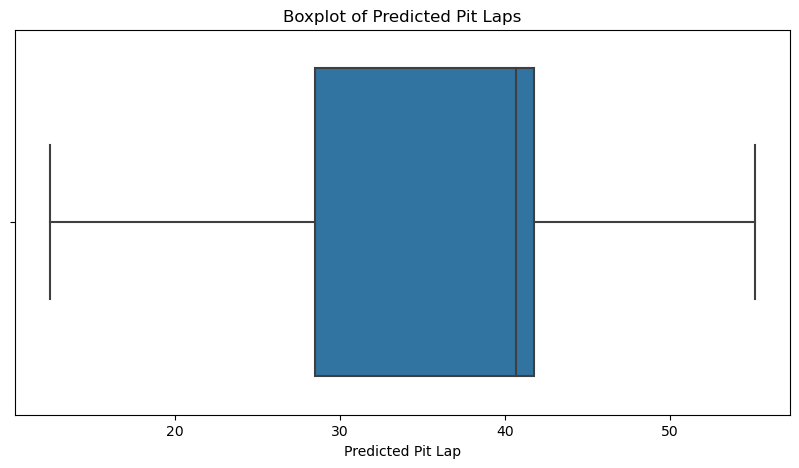

In [3]:
with mlflow.start_run():
    
    updated_formula1 = pd.read_csv("updated_formula1.csv")

    mlflow.log_text(str(updated_formula1.dtypes), 'data_schema.txt')

    features_to_drop = ['date', 'pit_time']
    updated_formula1 = updated_formula1.drop(columns=features_to_drop, errors='ignore')
    updated_formula1['pit_duration'] = pd.to_numeric(updated_formula1['pit_duration'], errors='coerce')
    updated_formula1.dropna(inplace=True)
    
    print(updated_formula1.isnull().sum())
    updated_formula1.dropna(inplace=True)

    numeric_cols = updated_formula1.select_dtypes(include=[np.number])

    Q1 = numeric_cols.quantile(0.25)
    Q3 = numeric_cols.quantile(0.75)
    IQR = Q3 - Q1

    outlier_mask = ((numeric_cols < (Q1 - 1.5 * IQR)) | (numeric_cols > (Q3 + 1.5 * IQR))).any(axis=1)
    updated_formula1 = updated_formula1[~outlier_mask]

    print(updated_formula1.describe())

    # Splitting data into train, validation, and test sets
    X = updated_formula1.drop('pit_lap', axis=1)
    y = updated_formula1['pit_lap']
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    xgb_model = XGBRegressor(n_estimators=50, verbosity=1, early_stopping_rounds=10)
    eval_set = [(X_val_scaled, y_val)] 

    xgb_model.fit(X_train_scaled, y_train, eval_set=eval_set, verbose=True)
    
    validation_predictions = xgb_model.predict(X_val_scaled)
    rmse = np.sqrt(mean_squared_error(y_val, validation_predictions))
    mlflow.log_metric("RMSE", rmse)

    test_predictions = xgb_model.predict(X_test_scaled)
    rmse_final = np.sqrt(mean_squared_error(y_test, test_predictions))
    mae_final = np.mean(np.abs(test_predictions - y_test))

    mlflow.log_metric("Final RMSE", rmse_final)
    mlflow.log_metric("Final MAE", mae_final)

    # Log model
    mlflow.sklearn.log_model(xgb_model, "model")

    # Save and log plots
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=test_predictions)
    plt.title('Boxplot of Predicted Pit Laps')
    plt.xlabel('Predicted Pit Lap')
    plt.savefig("predictions_boxplot.png")
    mlflow.log_artifact("predictions_boxplot.png")

    mlflow.end_run()

print("Experiment tracking completed with MLflow.")

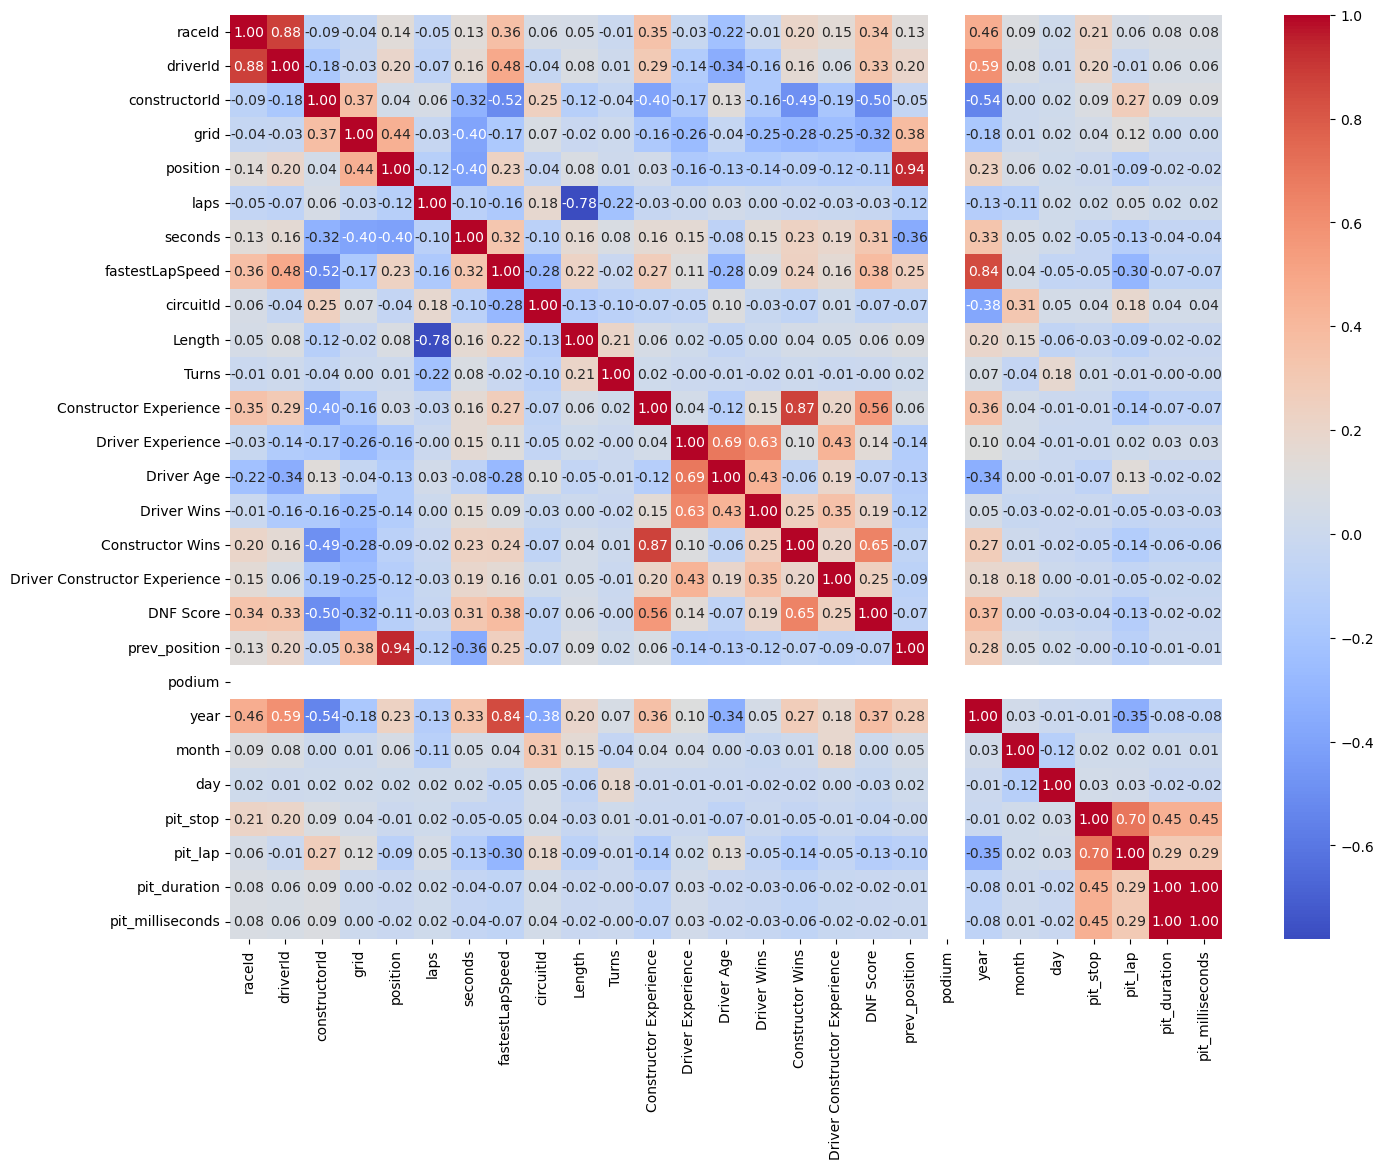

In [4]:
plt.figure(figsize=(16, 12))
sns.heatmap(updated_formula1.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

# Model training

In [5]:
X = updated_formula1.drop('pit_lap', axis=1)
y = updated_formula1['pit_lap']

# splitting data into 70% train, 20% validation, and 10% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [7]:
# model training
xgb_model = XGBRegressor(n_estimators=50, verbosity=1)
xgb_model.fit(X_train_scaled, y_train, eval_set=[(X_val_scaled, y_val)], early_stopping_rounds=10, verbose=True)

validation_predictions = xgb_model.predict(X_val_scaled)
rmse = np.sqrt(np.mean((validation_predictions - y_val) ** 2))
print("Root Mean Squared Error on Validation Set:", rmse)

[0]	validation_0-rmse:10.01486
[1]	validation_0-rmse:7.95844
[2]	validation_0-rmse:6.71765
[3]	validation_0-rmse:5.99276
[4]	validation_0-rmse:5.64308
[5]	validation_0-rmse:5.47982
[6]	validation_0-rmse:5.40743
[7]	validation_0-rmse:5.36626
[8]	validation_0-rmse:5.33134
[9]	validation_0-rmse:5.35630
[10]	validation_0-rmse:5.36822
[11]	validation_0-rmse:5.38237
[12]	validation_0-rmse:5.37305
[13]	validation_0-rmse:5.38610
[14]	validation_0-rmse:5.42495
[15]	validation_0-rmse:5.44045
[16]	validation_0-rmse:5.44039
[17]	validation_0-rmse:5.44492
Root Mean Squared Error on Validation Set: 5.331335694188733


/Applications/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [8]:
test_predictions = xgb_model.predict(X_test_scaled)
predicted_results_df = pd.DataFrame({
    'raceId': X_test['raceId'].values,
    'driverId': X_test['driverId'].values,
    'circuitId': X_test['circuitId'].values,
    'constructorId': X_test['constructorId'].values,
    'grid': X_test['grid'].values,
    'position': X_test['position'].values,
    'predictedPitLap': test_predictions
})

In [9]:
predicted_results_df.to_csv('predicted pit lap results.csv', index=False)
print("The predicted pit lap results CSV file has been saved.")

The predicted pit lap results CSV file has been saved.


# Visualizing

In [10]:
predicted_results_df.head()

,raceId,driverId,circuitId,constructorId,grid,position,predictedPitLap
0,238,86,27,18,20,15,53.257736
1,932,828,7,15,12,14,39.148758
2,37,24,2,5,16,17,40.675491
3,218,76,13,24,18,12,24.053928
4,131,8,7,1,5,4,31.200844


/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


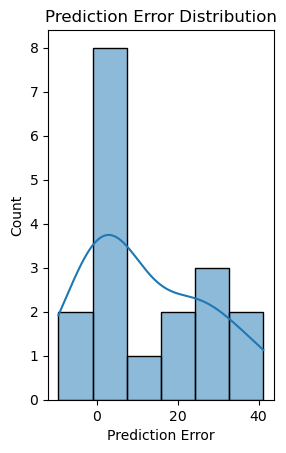

In [11]:
plt.subplot(1, 2, 2)
sns.histplot(predicted_results_df['predictedPitLap'] - y_test, kde=True)
plt.title('Prediction Error Distribution')
plt.xlabel('Prediction Error')
plt.show()

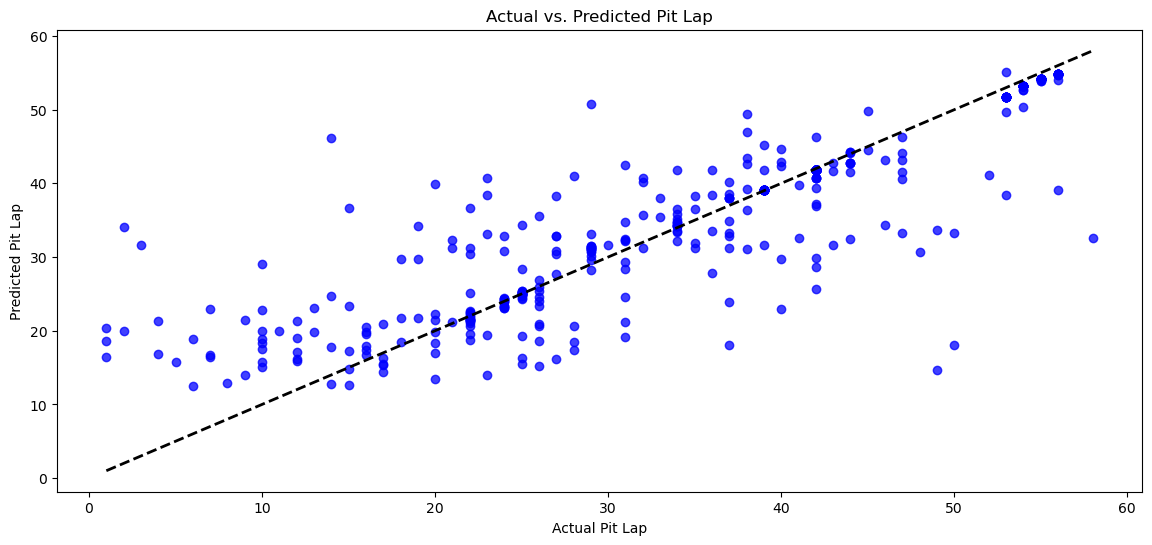

In [12]:
plt.figure(figsize=(14, 6))
plt.scatter(y_test, test_predictions, alpha=0.75, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) 
plt.xlabel('Actual Pit Lap')
plt.ylabel('Predicted Pit Lap')
plt.title('Actual vs. Predicted Pit Lap')
plt.show()

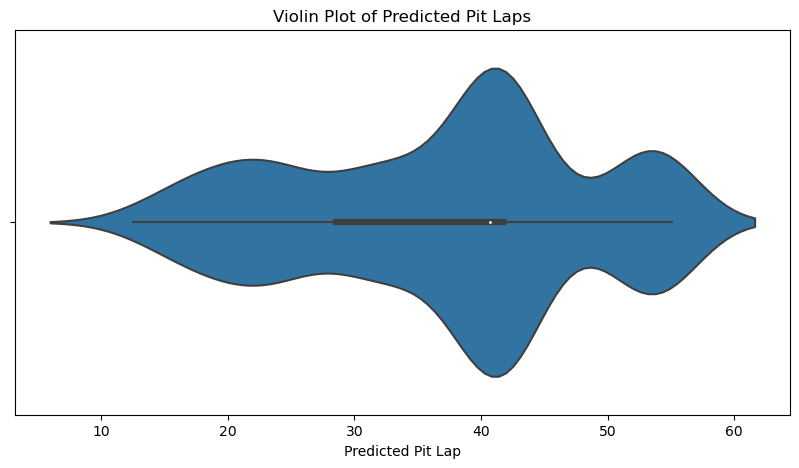

In [13]:
# violin plot for more detailed distribution visualization
plt.figure(figsize=(10, 5))
sns.violinplot(x=predicted_results_df['predictedPitLap'])
plt.title('Violin Plot of Predicted Pit Laps')
plt.xlabel('Predicted Pit Lap')
plt.show()

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


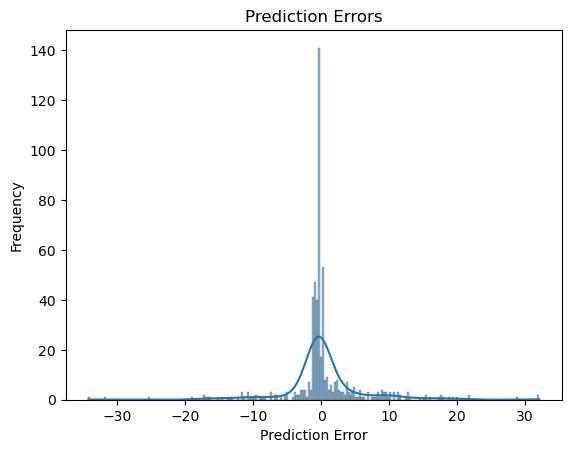

In [14]:
errors = test_predictions - y_test
sns.histplot(errors, kde=True)
plt.title('Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()

In [15]:
# calculating RMSE and MAE
rmse_final = np.sqrt(np.mean((predicted_results_df['predictedPitLap'] - y_test)**2))
mae_final = np.mean(np.abs(predicted_results_df['predictedPitLap'] - y_test))

print(f"Final Root Mean Squared Error (RMSE): {rmse_final}")
print(f"Final Mean Absolute Error (MAE): {mae_final}")

Final Root Mean Squared Error (RMSE): 19.241431908375688
Final Mean Absolute Error (MAE): 14.099479622311062


In [16]:
updated_formula1.to_csv('updated_cleaned_formula1.csv', index=False)
print("Cleaned and updated data saved as 'updated_cleaned_formula1.csv'.")

Cleaned and updated data saved as 'updated_cleaned_formula1.csv'.


In [17]:
# pip install mlflow

---------

# RACE RESULT PREDICTION

In [18]:
formula1 = pd.read_csv("formula1.csv")
circuits = pd.read_csv("circuits.csv")
drivers = pd.read_csv("drivers.csv")

In [19]:
def detect_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    outlier_step = 1.5 * IQR
    return data[(data < Q1 - outlier_step) | (data > Q3 + outlier_step)]

In [20]:
numeric_cols = formula1.select_dtypes(include=[np.number]).columns
outlier_data = {col: detect_outliers(formula1[col]) for col in numeric_cols}
outlier_summary = {col: len(outliers) for col, outliers in outlier_data.items() if len(outliers) > 0}
print("Outlier Summary:", outlier_summary)

Outlier Summary: {'constructorId': 1625, 'laps': 40, 'seconds': 12, 'circuitId': 1018, 'Length': 72, 'Turns': 340, 'Constructor Experience': 717, 'Driver Experience': 212, 'Driver Age': 12, 'Driver Wins': 1452, 'Constructor Wins': 51, 'Driver Constructor Experience': 535, 'DNF Score': 201, 'podium': 2288}


In [21]:
formula1['year'] = pd.to_datetime(formula1['date']).dt.year
formula1['month'] = pd.to_datetime(formula1['date']).dt.month
formula1['day'] = pd.to_datetime(formula1['date']).dt.day
columns_to_remove = ['date']

formula1.drop(columns = columns_to_remove, inplace = True)

In [22]:
features_to_scale = [col for col in formula1.columns if col not in ['position', 'driverId', 'circuitId']]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(formula1[features_to_scale])
X = pd.DataFrame(scaled_data, columns=features_to_scale)
y = formula1['position']

In [23]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, range(len(formula1)), test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100),
    "XGBoost": XGBRegressor(n_estimators=100, verbosity=0),  
    "CatBoost": CatBoostRegressor(n_estimators=100, verbose=0) 
}

In [24]:
model_scores = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    model_scores[name] = rmse
print("Model Scores:", model_scores)

Model Scores: {'Linear Regression': 0.8646610064870331, 'Decision Tree': 0.5245529835881914, 'Random Forest': 0.3700924651615698, 'Gradient Boosting': 0.32543999154911485, 'XGBoost': 0.3663024035448837, 'CatBoost': 0.3596604211769906}


In [25]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(estimator = RandomForestRegressor(random_state=42),
                           param_grid = param_grid, cv = 5, scoring = 'neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
print("Best Random Forest parameters:", grid_search.best_params_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Random Forest parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [26]:
dl_predictions = model.predict(X_test).flatten()
predicted_results_df = pd.DataFrame({
    'driverId': formula1.iloc[indices_test]['driverId'].values,
    'circuitId': formula1.iloc[indices_test]['circuitId'].values,
    'predictedPosition': dl_predictions
})

predicted_results_df.to_csv('Predicted Race Positions.csv', index=False)
print(predicted_results_df.head(), "The CSV file has been saved.")

   driverId  circuitId  predictedPosition
0        30         70           1.012426
1        35          1           4.981583
2        84         21           5.051294
3        39         12          17.997280
4        21         22          11.999163 The CSV file has been saved.
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   3.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; tot

[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   3.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   3.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   3.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.0s
[CV] END max_depth=None

[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   3.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   3.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   3.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.0s
[CV] END max_depth=None

[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   3.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   3.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.0s
[CV] END max_depth=None

[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   3.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=No